# Análisis de blockchain

En caso de que no conozcas nada sobre blockchain puede reproducir el siguiente video.

In [1]:
import IPython.display
IPython.display.HTML('<iframe width="750" height="430" src="https://www.youtube.com/embed/Lx9zgZCMqXE?rel=0&amp;controls=1&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>')

C:\Users\bogda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\display.py:419: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


## Configuración básica

Aquí vamos a importar el módulo pyspar y configurar una sesion SparkSession, por defecto se va a ejecutar en local con un solo ejecutor de spark.
Como vamos a tratar datos pequeños no tiene sentido correrlo en un cluster, pero estamos abiertos a esa posibilidad si lo necesitaramos cambiando el local por la ip del cluster.


In [ ]:
import pyspark
from pyspark.context import SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.functions import *

spark = SparkSession.builder \
                    .master("local[4]") \
                    .config("spark.driver.memory", "4g") \
                    .getOrCreate()

sc = spark.sparkContext

## Cargando los datos

Para obtener el grafo representando las transacciones en la red Bitcoin, necesitamos cargar el conjunto de nodos representando las carteras, y el conjunto de artistas representando cada transaccion. Por ejemplo vamos a usar dos ficheros .parquet que fueron generados de los primeros bloques de blockchain.

In [ ]:
raw_nodes = spark.read.load("/tmp/nodes1.parquet") \
                      .withColumnRenamed("_1", "id") \
                      .withColumnRenamed("_2", "Address")
raw_nodes.show(5)

Como podemos observar, cara fila en la columna de Address contiene la cadena `bitcoinaddress_<hash>`, donde el hash es la dirección actual del bloque. 
Vamos a eliminar este prefijo.

In [ ]:
nodes = raw_nodes.withColumn("Address", regexp_replace("Address", "bitcoinaddress_", "")).cache()
nodes.show(5)

Podemos también verificar que estas direcciones son reales en https://blockchain.info/address/. 

In [ ]:
random_address = nodes.rdd.takeSample(False, 1)[0][1]
IPython.display.Markdown('link of the random wallet: https://blockchain.info/address/' + random_address)

In [ ]:
raw_edges = spark.read.load("/tmp/edges1.parquet") \
                      .withColumnRenamed("srcId", "src") \
                      .withColumnRenamed("dstId", "dst") \
                      .drop("attr") \
                      .cache()
raw_edges.show(5)
raw_edges.count()

## Limpieza de datos

Eliminar las auto referencias

In [ ]:
edges = raw_edges.filter("src != dst")
edges.show(5)
edges.count()

## Construyendo la representación del grafo

In [ ]:
from graphframes import *

g = GraphFrame(nodes, edges).cache()

#### Calculando el grado del vértice

In [ ]:
vertexDegreesAndIds = g.inDegrees.join(g.outDegrees, "id")
vertexDegrees = vertexDegreesAndIds.drop("id")
vertexDegrees.show(5, False)

#### Calcular algunas estadísticas básicas

In [ ]:
vertexDegrees.describe() \
             .show()

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import seaborn as sns
import numpy as np
from scipy import stats
sns.set(color_codes=True)

_ = sns.countplot([int(i.inDegree) for i in vertexDegrees.sample(False, 0.003).select("inDegree").collect()])

In [ ]:
_ = sns.countplot([int(i.outDegree) for i in vertexDegrees.sample(False, 0.003).select("outDegree").collect()])

In [ ]:
sns.jointplot(x="inDegree", y="outDegree", data=vertexDegrees.sample(False, 0.01, 42).toPandas());

In [ ]:
vertexDegrees.select(corr("inDegree", "outDegree")) \
             .show()

In [ ]:
probs = [i*1.0/20 for i in range(0,20)]
quantiles = vertexDegrees.approxQuantile("inDegree", probs, 0.03)
quantiles

In [ ]:
import pandas as pd
p_df = pd.DataFrame({'quantiles': quantiles, 'probabilities': probs})

sns.lmplot(x="probabilities", y="quantiles", fit_reg=False, data=p_df)

In [ ]:
def create_graph(id):
    nodes = spark.read.load("/tmp/nodes" + id +".parquet").withColumnRenamed("_1", "id")
    raw_edges = spark.read.load("/tmp/edges" + id +".parquet") \
                          .withColumnRenamed("srcId", "src").withColumnRenamed("dstId", "dst") \
                          .drop("attr")

    edges = raw_edges.filter("src != dst")
    self_loops = raw_edges.count() - edges.count()
    print("Graph " + id + " - self-loops count: " + str(self_loops))
    g = GraphFrame(nodes, edges)
    degrees = g.inDegrees.join(g.outDegrees, "id").drop("id")
    return [g, degrees]

# g1 ~ blkfiles 051-054 ~ 2013~04
# g2 ~ blkfiles 401-404 ~ 2015~12
g1, degrees1 = create_graph("1")
g2, degrees2 = create_graph("2")

In [ ]:
degrees1.describe().show()
degrees2.describe().show()

In [ ]:
def plot_quantiles(degrees):
    probs = [i*1.0/15 for i in range(0,15)]
    quantiles = degrees.approxQuantile("outDegree", probs, 0.03)
    p_df = pd.DataFrame({'quantiles': quantiles, 'probabilities': probs})
    sns.lmplot(x="probabilities", y="quantiles", fit_reg=False, data=p_df)

plot_quantiles(degrees1)
plot_quantiles(degrees2)

#### Encontrar patrones en el grafo

In [ ]:
graph_with_degrees = GraphFrame(g.vertices.join(vertexDegreesAndIds, "id"), edges)
graph_with_degrees.vertices.show()


motifs = graph_with_degrees.find("(a)-[]->(b)") \
                           .filter("a.outDegree > 1000") \
                           .filter("a.inDegree = 1") \
                           .filter("b.outDegree = 1") \
                           .filter("b.inDegree > 1000")
motifs.show()
motifs.count()

## Visualización de un sub-grafo

Nuestros datos contienen muchos nodos y aristas así que vamos a mostrar solo una pequeña fracción del grafo de transacciones. Vamos a mostrar también todas las transacciones salientes de una dirección específica de bitcoin.

In [ ]:
from pyspark.sql.functions import col
import random

vertexOutDegrees = g.outDegrees
senders = vertexOutDegrees.join(nodes, vertexOutDegrees.id == nodes.id) \
                          .drop("id") \
                          .orderBy("outDegree", ascending=False)

# feel free to use any address that is present in the dataset
address = senders.take(1000)[999].Address

sub_graph = g.find("(src)-[e]->(dst)") \
             .filter(col('src.Address') == address)
    
def node_to_dict(r):
    return {
        'id': r[0],
        'label': r[1],
        'x': random.uniform(0,1),
        'y': random.uniform(0,1),
        'size': random.uniform(0.2,1)
    }

sub_nodes = sub_graph.select("dst.id", "dst.Address").distinct()
sub_edges = sub_graph.select("e.src", "e.dst")

target_nodes_dict = map(node_to_dict, sub_nodes.collect())

def edge_to_dict(i, r):
    return {
        'id': i,
        'source': r[0],
        'target': r[1]
    }

sub_edges_dict = [edge_to_dict(i, r) for i, r in enumerate(sub_edges.collect())]

target_nodes_dict.append({
    'id': sub_edges.first()['src'],
    'label': address,
    'color': '#999',
    'x': -1,
    'y': 0.5,
    'size': 2
})

In [ ]:
%%javascript
require.config({
    paths: {
        sigmajs: 'https://cdnjs.cloudflare.com/ajax/libs/sigma.js/1.2.0/sigma.min'
    }
});

require(['sigmajs']);

In [ ]:
from IPython.core.display import display, HTML
from string import Template
import json

js_text_template = Template(open('js/sigma-graph.js','r').read())

graph_data = { 'nodes': target_nodes_dict, 'edges': sub_edges_dict }

js_text = js_text_template.substitute({'graph_data': json.dumps(graph_data),
                                       'container': 'graph-div'})

html_template = Template('''
<div id="graph-div" style="height:400px"></div>
<script> $js_text </script>
''')

HTML(html_template.substitute({'js_text': js_text}))

In [ ]:
import networkx as nx
G = nx.Graph()
G.add_edges_from(sub_edges.collect())

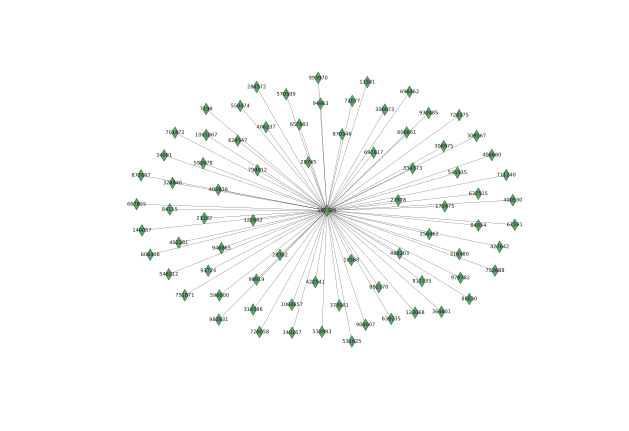

In [ ]:
import matplotlib.pyplot as plt
options = {
    'node_color': 'g',
    'node_size': 70,
    'width': 0.2,
    'node_shape': 'd',
    'with_labels': True,
    'font_size': 5,
}
nx.draw(G, **options)

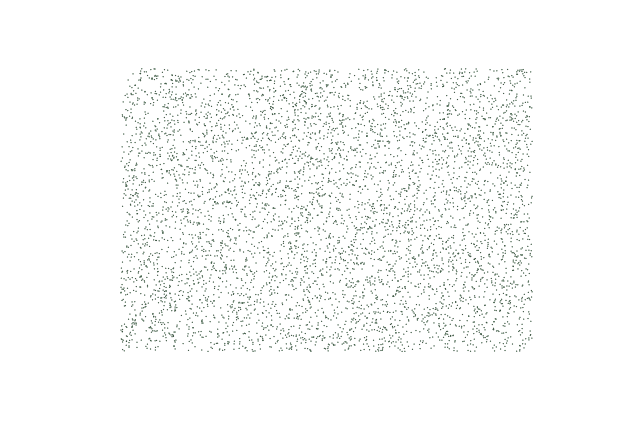

In [ ]:
sample_data = edges.sample(False, 0.0004).collect()
G2 = nx.Graph()
G2.add_edges_from(sample_data)

options = {
    'node_color': 'g',
    'node_size': 1,
    'width': 0.05,
    'node_shape': 'o',
    'vmin': 100.1,
    'vmax': 10.1,
    'with_labels': False,
}
nx.draw_random(G2, **options)

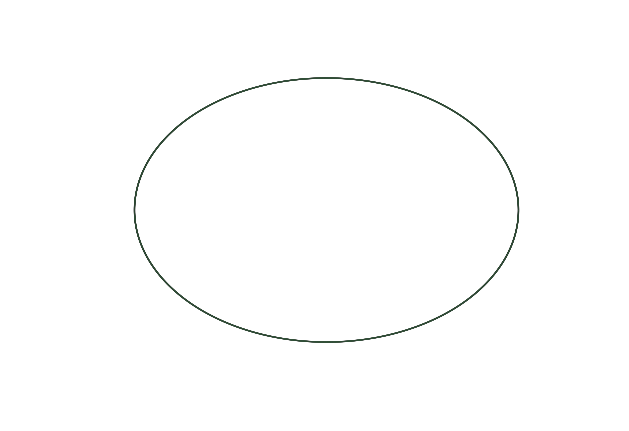

In [ ]:
nx.draw_shell(G2, **options)

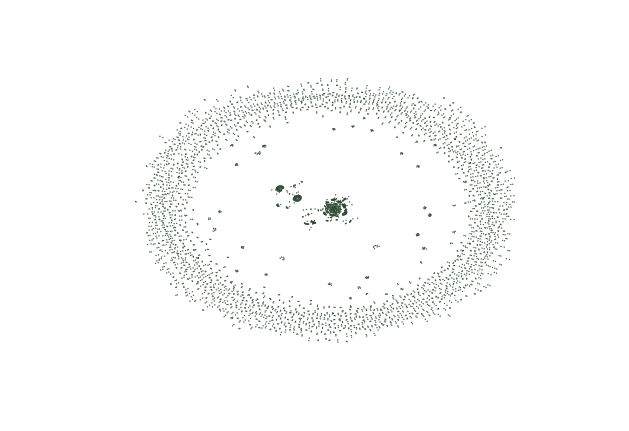

In [ ]:
nx.draw_spring(G2, **options)

Unfortunatelly, the plotting mechanism in `networkx` doesn't support the zooming, but it's possible to export the data and explore them by tools like `Gephi`.